In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-review-data/WalmartProducts.csv
/kaggle/input/walmart-product-reviews-dataset/marketing_sample_for_walmart_com-walmart_product_reviews__20200401_20200630__30k_data.csv


# **Load Library**

In [2]:
from warnings import filterwarnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import Word, TextBlob

import tensorflow as tf
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,TFBertForSequenceClassification
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Load Data**

In [3]:
os.listdir("../input/walmart-product-reviews-dataset/")
walmart2 = pd.read_csv("../input/walmart-product-reviews-dataset/marketing_sample_for_walmart_com-walmart_product_reviews__20200401_20200630__30k_data.csv")
walmart = pd.read_csv("../input/walmart-review-data/WalmartProducts.csv")
print(walmart.shape)

(30006, 19)


# **Filtering and single feature exploration**

In [4]:
walmart.head()

,index,Uniq Id,Crawl Timestamp,Pageurl,Website,Title,Rating,Review,Reviewer Name,Review Upvotes,Review Downvotes,Verified Purchaser,Recommended Purchase,Review Date,Five Star,Four Star,Three Star,Two Star,One Star
0,0,ee40ad5e6211d47a92fa1962938fad16,2020-03-17 03:37:35 +0000,https://www.walmart.com/reviews/product/15066091,walmart.com,"Sylvania 9"" Portable Dvd Player With Swivel Sc...",5.0,This product works great. It's exactly what I ...,Diane,0,0,No,No,12/4/2018,133.0,58.0,15.0,9.0,34.0
1,1,d10f87c07c206c72b0b5ddbf90541b38,2020-03-27 13:15:01 +0000,https://www.walmart.com/reviews/product/247042233,walmart.com,NaN,1.0,My carrier said this phone had been activated ...,Bren,0,0,No,No,12/21/2018,9.0,0.0,1.0,2.0,8.0
2,2,ef254e936e02a1b2bdaf89dd51b73403,2020-02-17 04:49:37 +0000,https://www.walmart.com/reviews/product/649827918,walmart.com,"VIZIO 65"" Class 4K UHD Quantum SmartCast Smart...",5.0,The picture on this TV is better than any TV I...,Hieronymesque,0,0,Yes,No,12/25/2019,180.0,39.0,5.0,8.0,13.0
3,3,183ab6b4ec58daae79c66d0151400b63,2020-02-17 03:11:54 +0000,https://www.walmart.com/reviews/product/665198047,walmart.com,TSV For Fitbit Charge 3 USB Charging Cradle Wa...,5.0,NaN,D,0,0,No,No,4/2/2019,2.0,3.0,0.0,0.0,0.0
4,4,03628759aaed53a0b9d137bca9991c5d,2020-02-07 01:17:14 +0000,https://www.walmart.com/reviews/product/125301514,walmart.com,AKG K92 Closed-Back Headphones - Stereo - Wire...,5.0,Very well-balanced between the highs and the l...,Dubbsta,52,1,No,No,12/9/2017,9.0,3.0,0.0,0.0,2.0


In [5]:
walmart.columns

Index(['index', 'Uniq Id', 'Crawl Timestamp', 'Pageurl', 'Website', 'Title',
       'Rating', 'Review', 'Reviewer Name', 'Review Upvotes',
       'Review Downvotes', 'Verified Purchaser', 'Recommended Purchase',
       'Review Date', 'Five Star', 'Four Star', 'Three Star', 'Two Star',
       'One Star'],
      dtype='object')

In [6]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30006 entries, 0 to 30005
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 30006 non-null  int64  
 1   Uniq Id               30006 non-null  object 
 2   Crawl Timestamp       30006 non-null  object 
 3   Pageurl               30006 non-null  object 
 4   Website               30006 non-null  object 
 5   Title                 24412 non-null  object 
 6   Rating                30006 non-null  float64
 7   Review                25821 non-null  object 
 8   Reviewer Name         28358 non-null  object 
 9   Review Upvotes        30006 non-null  int64  
 10  Review Downvotes      30006 non-null  int64  
 11  Verified Purchaser    30006 non-null  object 
 12  Recommended Purchase  30006 non-null  object 
 13  Review Date           30006 non-null  object 
 14  Five Star             29910 non-null  float64
 15  Four Star          

In [7]:
walmart.isna().sum()

index                      0
Uniq Id                    0
Crawl Timestamp            0
Pageurl                    0
Website                    0
Title                   5594
Rating                     0
Review                  4185
Reviewer Name           1648
Review Upvotes             0
Review Downvotes           0
Verified Purchaser         0
Recommended Purchase       0
Review Date                0
Five Star                 96
Four Star                 96
Three Star                96
Two Star                  96
One Star                  96
dtype: int64

In [8]:
walmart = walmart.drop(columns=['Five Star','Four Star','Three Star','Two Star','One Star'])
walmart.shape

(30006, 14)

In [9]:
walmart = walmart[walmart['Review'].notna()]
walmart.shape

(25821, 14)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 0, 'Month')]

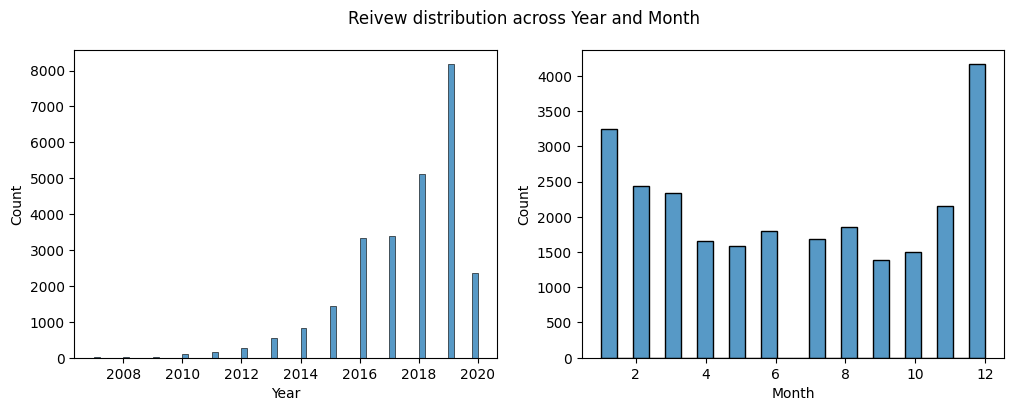

In [11]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('Reivew distribution across Year and Month')
sns.histplot(ax=axes[0],data=pd.DatetimeIndex(walmart['Review Date']).year)
axes[0].set(xlabel='Year')
sns.histplot(ax=axes[1],data=pd.DatetimeIndex(walmart['Review Date']).month)
axes[1].set(xlabel='Month')

The number of reviews increasing with years. For year 2020, we only have reviews until March. The number of reviews in Decemember and January is much higher than other months because these 2 months are holiday season.

In [12]:
set(list(pd.DatetimeIndex(walmart['Crawl Timestamp']).year))

{2020}

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Day', ylabel='Count'>

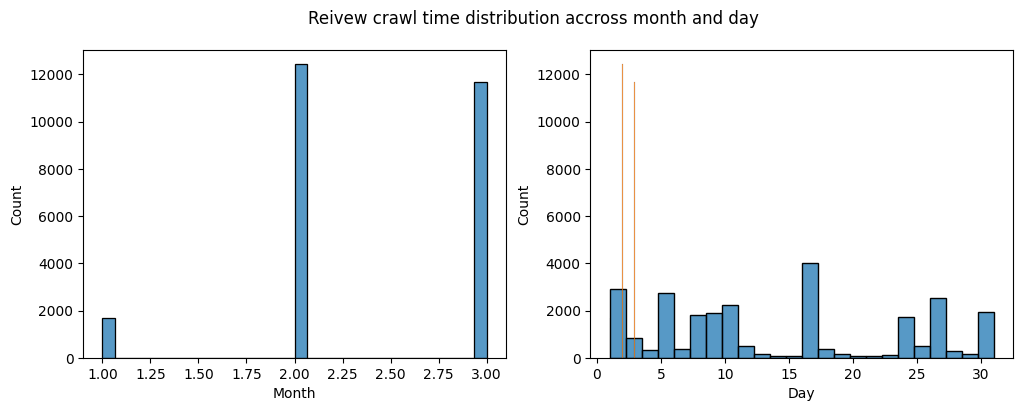

In [13]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('Reivew crawl time distribution accross month and day')
sns.histplot(ax=axes[0],data=pd.DatetimeIndex(walmart['Crawl Timestamp']).month)
axes[0].set(xlabel='Month')
sns.histplot(ax=axes[1],data=pd.DatetimeIndex(walmart['Crawl Timestamp']).day)
axes[1].set(xlabel='Day')

sns.histplot(pd.DatetimeIndex(walmart['Crawl Timestamp']).month)

The reviews are crawled in a range of 3 months in 2020. Although I don't know how this information can contribute in the analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

[Text(0.5, 0, 'Recommended Purchase')]

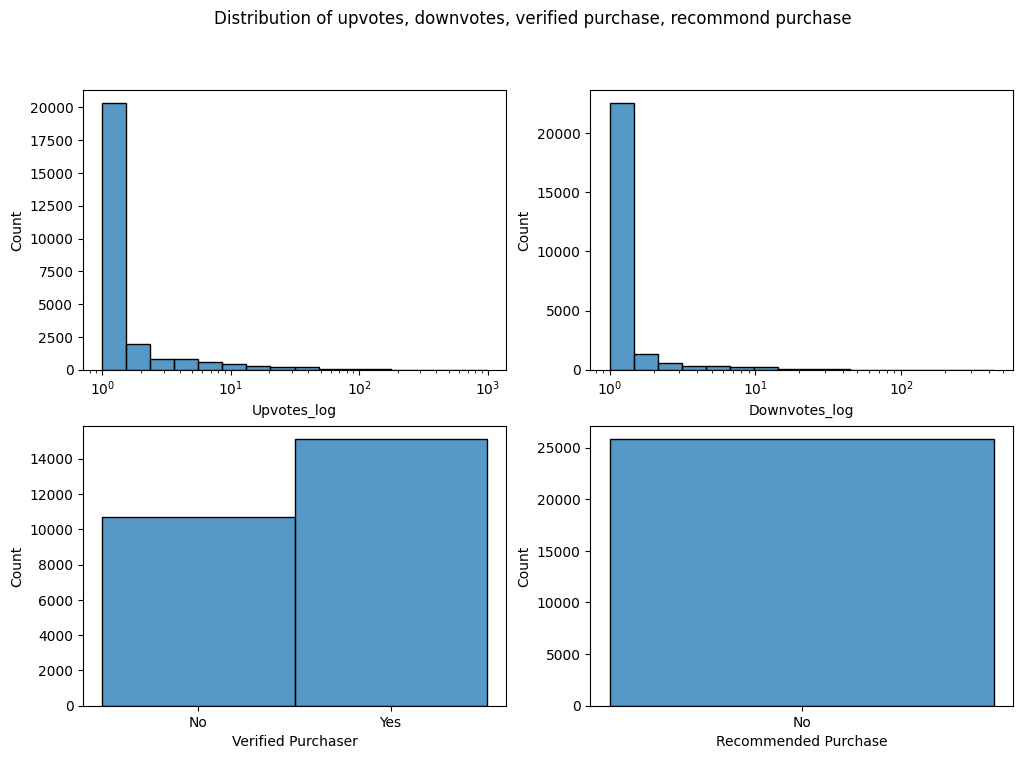

In [14]:
fig,axes = plt.subplots(2,2,figsize=(12,8))
fig.suptitle('Distribution of upvotes, downvotes, verified purchase, recommond purchase')
sns.histplot(ax=axes[0,0],data=walmart['Review Upvotes']+1,log_scale=True)
axes[0,0].set(xlabel='Upvotes_log')
sns.histplot(ax=axes[0,1],data=walmart['Review Downvotes']+1,log_scale=True)
axes[0,1].set(xlabel='Downvotes_log')
sns.histplot(ax=axes[1,0],data=walmart['Verified Purchaser'])
axes[1,0].set(xlabel='Verified Purchaser')
sns.histplot(ax=axes[1,1],data=walmart['Recommended Purchase'])
axes[1,1].set(xlabel='Recommended Purchase')

For most of revies the number of upvotes and downvotes are 0. Only few views have nozero upvotes or downvotes. The number of verified and non-verified purchaser are similar. For Recommended purchase, the value is always 'NO'. So I will delete the column.

In [10]:
walmart=walmart.drop(columns=['Recommended Purchase'])
walmart.shape

(25821, 13)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Rating', ylabel='Count'>

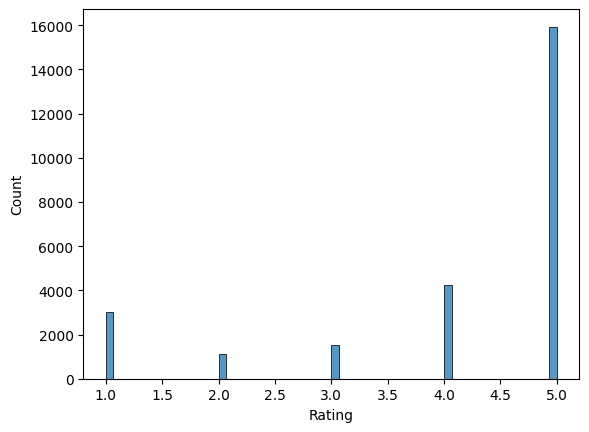

In [11]:
sns.histplot(walmart['Rating'])

5 stars is much higher than other cases.

**Feature Correlation Exploration**

In [17]:
Rating_Year = pd.crosstab(walmart['Rating'],pd.DatetimeIndex(walmart['Review Date']).year)
Rating_Year = Rating_Year/Rating_Year.sum()
Rating_Month = pd.crosstab(walmart['Rating'],pd.DatetimeIndex(walmart['Review Date']).month)
Rating_Month = Rating_Month/Rating_Month.sum()
Rating_Crawl_Month = pd.crosstab(walmart['Rating'],pd.DatetimeIndex(walmart['Crawl Timestamp']).month)
Rating_Crawl_Month = Rating_Crawl_Month/Rating_Crawl_Month.sum()
Rating_Crawl_Day = pd.crosstab(walmart['Rating'],pd.DatetimeIndex(walmart['Crawl Timestamp']).day)
Rating_Crawl_Day = Rating_Crawl_Day/Rating_Crawl_Day.sum()
Rating_Review_Upvotes = pd.crosstab(walmart['Rating'],pd.cut(walmart['Review Upvotes'],bins=[0,10,100,1000],include_lowest=True))
Rating_Review_Upvotes = Rating_Review_Upvotes/Rating_Review_Upvotes.sum()
Rating_Review_Downvotes = pd.crosstab(walmart['Rating'],pd.cut(walmart['Review Downvotes'],bins=[0,10,100,1000],include_lowest=True))
Rating_Review_Downvotes = Rating_Review_Downvotes/Rating_Review_Downvotes.sum()
Rating_Verified_Purchaser = pd.crosstab(walmart['Rating'],walmart['Verified Purchaser'])
Rating_Verified_Purchaser = Rating_Verified_Purchaser/Rating_Verified_Purchaser.sum()

[Text(0.5, 0, 'Crawl_Day')]

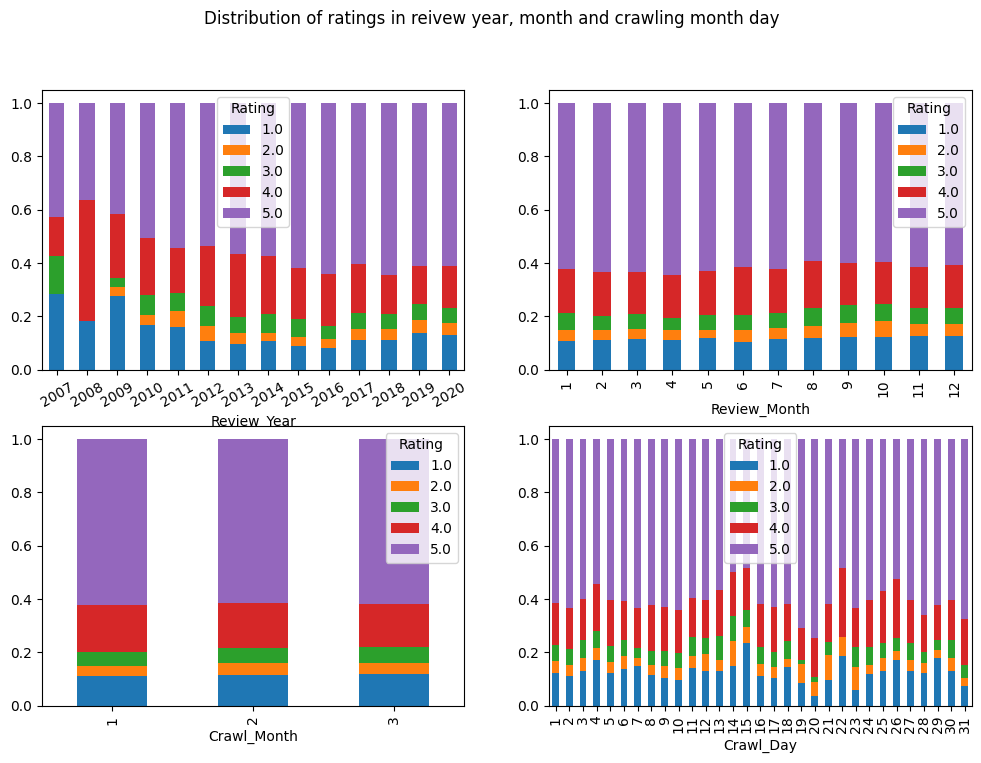

In [18]:
fig,axes = plt.subplots(2,2,figsize=(12,8))
fig.suptitle('Distribution of ratings in reivew year, month and crawling month day')
Rating_Year.transpose().plot.bar(ax=axes[0,0],stacked=True)
axes[0,0].set(xlabel='Review_Year')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(),rotation=30)
Rating_Month.transpose().plot.bar(ax=axes[0,1],stacked=True)
axes[0,1].set(xlabel='Review_Month')
Rating_Crawl_Month.transpose().plot.bar(ax=axes[1,0],stacked=True)
axes[1,0].set(xlabel='Crawl_Month')
Rating_Crawl_Day.transpose().plot.bar(ax=axes[1,1],stacked=True)
axes[1,1].set(xlabel='Crawl_Day')

[Text(0.5, 0, 'Verified_Purchaser')]

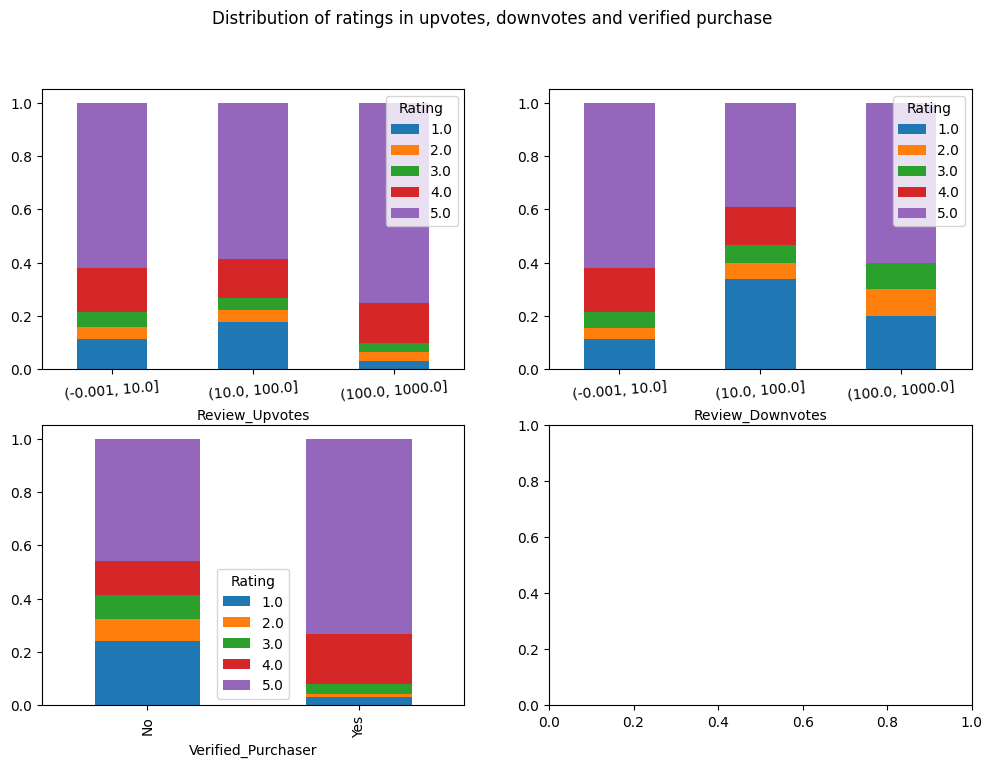

In [19]:
fig,axes = plt.subplots(2,2,figsize=(12,8))
fig.suptitle('Distribution of ratings in upvotes, downvotes and verified purchase')
Rating_Review_Upvotes.transpose().plot.bar(ax=axes[0,0],stacked=True)
axes[0,0].set(xlabel='Review_Upvotes')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(),rotation=5)
Rating_Review_Downvotes.transpose().plot.bar(ax=axes[0,1],stacked=True)
axes[0,1].set(xlabel='Review_Downvotes')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(),rotation=5)
Rating_Verified_Purchaser.transpose().plot.bar(ax=axes[1,0],stacked=True)
axes[1,0].set(xlabel='Verified_Purchaser')

Verified purhcaser tend to give high rating which means cusomer who give high ratings are more willing to verify their purhcase Or people who verify their purchase are more willing to give high ratings. It is interesting to check. Reivew upvotes means other customer aggree the reivewer's comments. Reivew downvotes means other customer disaggree the reivewer's comments. The ratings of 2, 3 and 4's upvotes fraction and downvotes fractions are generally not change. It seems that people are more likely to give upvotes and down votes for extreme ratings. We can find that for reivews with more than 100 upvotes, the fraction of 5 star increaed while fraction of 1 star decrease. The downvotes in [10,100) has higher fraction of 1 star and lower fraction of 5 start. The downvotes in [100, 1000) are not reliable becase the number of reviews is only 10.

#  **Semantic Analysis**

# **Text Preprocessing**

In [12]:
# transform to lower case
walmart['Review'] = walmart['Review'].str.lower()

In [13]:
# remove punctuations
walmart['Review'] = walmart['Review'].str.replace('[^\w\s]','',regex=True)

In [14]:
#remove number in the review text
walmart['Review'] = walmart['Review'].str.replace('\d', '', regex=True)

In [15]:
#remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
walmart['Review'] = walmart['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#remove rare words: remove words only appearing one time
words_count = pd.Series(' '.join(walmart['Review']).split()).value_counts()
rare_word = words_count[words_count<=1]
walmart['Review'] = walmart['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_word))

In [17]:
#Lemmatization:  reduces different inflected forms of words (like 'running' to 'run') to their base form.  
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [18]:
cmd = "unzip -d /usr/share/nltk_data/corpora/ /usr/share/nltk_data/corpora/wordnet.zip"
os.system(cmd)
os.system("ls /usr/share/nltk_data/corpora/wordnet*")

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

0

In [19]:
#I found that some verbs are not properly lemmatized
Word("running").lemmatize()

'running'

In [20]:
#Propoer tag should be added to make it works
Word("running").lemmatize('v')

'run'

In [21]:
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

# Lemmatize
sentence = "The striped bats are hanging on their feet for best"
lemmatize_with_postag(sentence)
#> 'The striped bat be hang on their foot for best'

'The striped bat be hang on their foot for best'

In [22]:
walmart['Review'] = walmart['Review'].apply(lambda x: lemmatize_with_postag(x))

# **Text Visualization**

In [36]:
#Count number of appearances
cf = walmart["Review"].apply(lambda x: pd.Series(x.split(" ")).value_counts()).sum(axis=0).reset_index()

In [37]:
cf.columns = ["words", "tf"]
cf_sorted = cf.sort_values(by='tf', ascending=False)

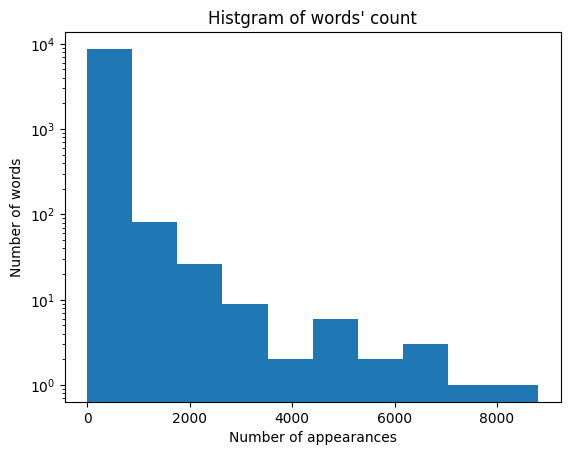

In [38]:
plt.hist(cf["tf"],log=True)
plt.title("Histgram of words' count")
plt.xlabel("Number of appearances")
plt.ylabel("Number of words")
plt.show()

Distribution of words' count indicate that most of words apears less than 2000 times. High appearances words are rare. 

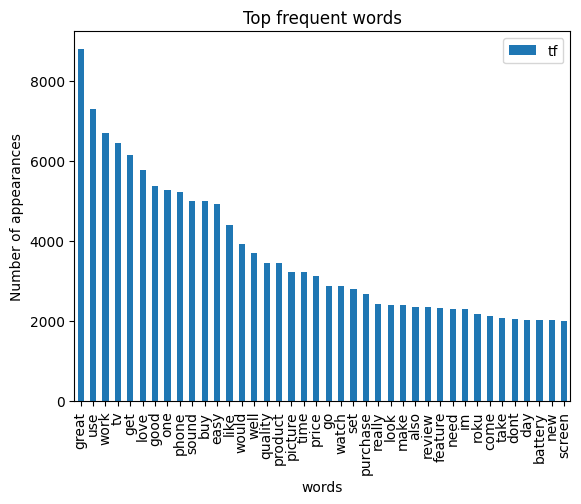

In [39]:
cf_sorted[cf_sorted["tf"] > 2000].plot.bar(x="words", y="tf")
plt.ylabel("Number of appearances")
plt.title("Top frequent words")
plt.show(block=True)

# **Word Clod**

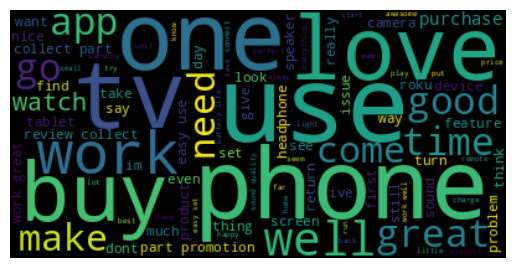

In [23]:
from wordcloud import WordCloud

text = " ".join(i for i in walmart.Review)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# **Sentiment Analysis**

In [24]:
#transform rating to positive and negative 
walmart["Senti"]=walmart["Rating"].apply(lambda x: "pos" if x > 3 else "neg")

In [25]:
walmart.head()

,index,Uniq Id,Crawl Timestamp,Pageurl,Website,Title,Rating,Review,Reviewer Name,Review Upvotes,Review Downvotes,Verified Purchaser,Review Date,Senti
0,0,ee40ad5e6211d47a92fa1962938fad16,2020-03-17 03:37:35 +0000,https://www.walmart.com/reviews/product/15066091,walmart.com,"Sylvania 9"" Portable Dvd Player With Swivel Sc...",5.0,product work great exactly look,Diane,0,0,No,12/4/2018,pos
1,1,d10f87c07c206c72b0b5ddbf90541b38,2020-03-27 13:15:01 +0000,https://www.walmart.com/reviews/product/247042233,walmart.com,NaN,1.0,carrier say phone activate yet purchase new ph...,Bren,0,0,No,12/21/2018,neg
2,2,ef254e936e02a1b2bdaf89dd51b73403,2020-02-17 04:49:37 +0000,https://www.walmart.com/reviews/product/649827918,walmart.com,"VIZIO 65"" Class 4K UHD Quantum SmartCast Smart...",5.0,picture tv well tv ive ever own life extremely...,Hieronymesque,0,0,Yes,12/25/2019,pos
4,4,03628759aaed53a0b9d137bca9991c5d,2020-02-07 01:17:14 +0000,https://www.walmart.com/reviews/product/125301514,walmart.com,AKG K92 Closed-Back Headphones - Stereo - Wire...,5.0,wellbalanced high low bass treble good volume ...,Dubbsta,52,1,No,12/9/2017,pos
5,5,7102ff804ecde89329af14dcf21d04b1,2020-03-01 10:26:04 +0000,https://www.walmart.com/reviews/product/149475379,walmart.com,Panasonic HD WiFi Camera KX-HN0002B,1.0,camera every one experience issue ghz support ...,Dave in SoCal,5,1,No,8/8/2018,neg


# **Modeling Exploration**

In [26]:
# Test-Train
train_x, test_x, train_y, test_y = train_test_split(walmart["Review"],
                                                    walmart["Senti"],
                                                    random_state=428)

In [27]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [28]:
# TF-IDF N-Gram Level (2,2)
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 2)).fit(train_x)
x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(train_x)
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

# **Logistic regression**

In [29]:
# Modelling(Logistic Regression - word level) 
log_model_word = LogisticRegression().fit(x_train_tf_idf_word, train_y)
y_pred_word = log_model_word.predict(x_test_tf_idf_word)

print(classification_report(y_pred_word, test_y))

              precision    recall  f1-score   support

         neg       0.61      0.85      0.71      1000
         pos       0.97      0.90      0.93      5456

    accuracy                           0.89      6456
   macro avg       0.79      0.87      0.82      6456
weighted avg       0.91      0.89      0.90      6456



In [30]:
cross_val_score(log_model_word, x_test_tf_idf_word, test_y, cv=5).mean()

0.8695785061140114

In [31]:
feature_importance = pd.DataFrame({'Feature': tf_idf_word_vectorizer.get_feature_names_out(), 'Importance': np.abs(log_model_word.coef_[0])})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
#feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

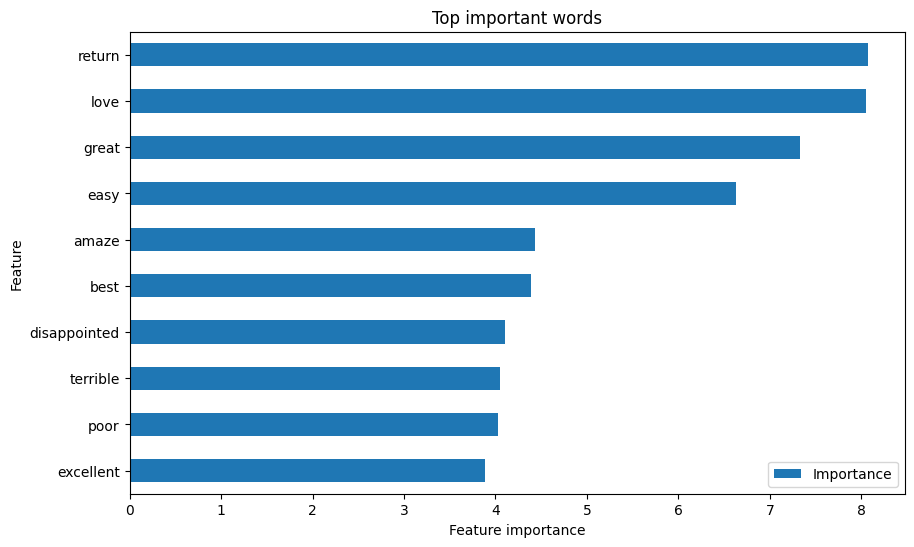

In [32]:
tmp = feature_importance.iloc[8438:,:]
tmp.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title("Top important words")
plt.xlabel("Feature importance")
plt.show()

Top import words indicate the most important single words that indicate reviewer's rating and sentiment. These words align with common sense.

In [33]:
# Modelling(Logistic Regression - ngram level) 
log_model_ngram = LogisticRegression().fit(x_train_tf_idf_ngram, train_y)
y_pred_ngram = log_model_ngram.predict(x_test_tf_idf_ngram)

print(classification_report(y_pred_ngram, test_y))

              precision    recall  f1-score   support

         neg       0.17      0.93      0.29       263
         pos       1.00      0.81      0.90      6193

    accuracy                           0.82      6456
   macro avg       0.59      0.87      0.59      6456
weighted avg       0.96      0.82      0.87      6456



In [53]:
len(log_model_ngram.coef_[0])

208664

In [54]:
len(tf_idf_ngram_vectorizer.get_feature_names_out())

208664

In [34]:
# Cross Validation
cross_val_score(log_model_ngram, x_test_tf_idf_ngram, test_y, cv=5).mean()

0.7871746048494819

In [35]:
ngram_importance = pd.DataFrame({'Feature': tf_idf_ngram_vectorizer.get_feature_names_out(), 'Importance': np.abs(log_model_ngram.coef_[0])})
ngram_importance = ngram_importance.sort_values('Importance', ascending=True)
#ngram_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [57]:
ngram_importance.shape

(208664, 2)

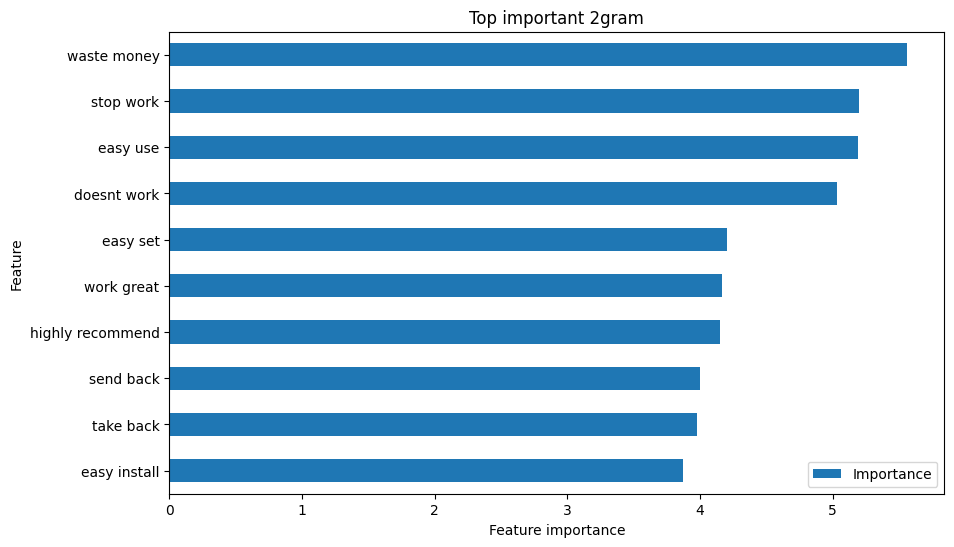

In [36]:
tmp = ngram_importance.iloc[208654:,:]
tmp.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title("Top important 2gram")
plt.xlabel("Feature importance")
plt.show()

Top import 2gram indicate the most important 2grams that indicate reviewer's rating and sentiment. These grams align with common sense. At the same time, we can find that 2 grams are more informational on how to get positive review from customers. 

Both single word and 2gram logistic regression analysis indicate that the data contains information to model the association between reveiws and ratings. 2gram's preforamnce is worse than single word may result from their much bigger feature space. But we can also find that 2gram more much more information time than single word modeling for us to understand the key features of service and product that could result in positive review from customer. In such a case, we could expect that using more complex model such as BERT, we could have better modeling performance and at the same time, we could get more infromational features to work on for improving service/product.

# **BERT Model**

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [38]:
x_train, x_val, y_train, y_val = train_test_split(train_x,
                                                    train_y,
                                                    test_size=0.25, 
                                                    stratify = train_y)

In [39]:
max_len= 256
X_train_encoded = tokenizer.batch_encode_plus(x_train.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
X_test_encoded = tokenizer.batch_encode_plus(test_x.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [40]:
senti_dict = {"pos": 1, "neg": 0}
Y_train_label = y_train.apply(lambda x: senti_dict[x])
Y_val_label = y_val.apply(lambda x: senti_dict[x])
Y_test_label = test_y.apply(lambda x: senti_dict[x])

In [41]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [45]:
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Y_train_label,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],Y_val_label),
    batch_size=32,
    epochs=3
)

Epoch 1/3
454/454 [==============================] - 525s 1s/step - loss: 0.3373 - accuracy: 0.8576 - val_loss: 0.2526 - val_accuracy: 0.8982
Epoch 2/3
454/454 [==============================] - 474s 1s/step - loss: 0.2220 - accuracy: 0.9128 - val_loss: 0.2463 - val_accuracy: 0.8984
Epoch 3/3
454/454 [==============================] - 474s 1s/step - loss: 0.1630 - accuracy: 0.9393 - val_loss: 0.2625 - val_accuracy: 0.8992


In [46]:
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    Y_test_label
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

202/202 [==============================] - 65s 320ms/step - loss: 0.2682 - accuracy: 0.9004
Test loss: 0.2681996524333954, Test accuracy: 0.9004027247428894


In [47]:
Y_test_pred = model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])
 

202/202 [==============================] - 67s 316ms/step


In [49]:
logits = Y_test_pred.logits
pred_labels = tf.argmax(logits, axis=1)
pred_labels = pred_labels.numpy()


In [50]:
print(classification_report(Y_test_label, pred_labels))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1405
           1       0.93      0.95      0.94      5051

    accuracy                           0.90      6456
   macro avg       0.86      0.84      0.85      6456
weighted avg       0.90      0.90      0.90      6456

